In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations, filterfalse
from gensim.models.keyedvectors import KeyedVectors
import random
import sys
import os
import pickle
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import scipy.stats
import re

In [ ]:
X = ["woman","mother"] 
Y = ["man","father"] 
A = ["health","happy"]
B = ["pollute","tragedy" ] 

In [ ]:
B=np.matrix([[1, 2], [3, 4],[5,6]])
B
combi=list(combinations(B,2))
print(combi)
print(len(B))

[(matrix([[1, 2]]), matrix([[3, 4]])), (matrix([[1, 2]]), matrix([[5, 6]])), (matrix([[3, 4]]), matrix([[5, 6]]))]
3


# Downloading the glove pretrained word vectors 
Common crawl (840B tokens, 2.2M Vocab, cased, 300d vectors)

Ref: https://nlp.stanford.edu/projects/glove/

In [ ]:
!if [ ! -f /glove.840B.300d.txt ]; then gdown https://drive.google.com/uc?id=1J2Fk2FjFQGO3SA9aoG37fy85TRv664Br; fi

Downloading...
From: https://drive.google.com/uc?id=1J2Fk2FjFQGO3SA9aoG37fy85TRv664Br
To: /content/glove.840B.300d.txt
5.65GB [00:39, 143MB/s]


## Converting the glove vectors in word2vec format

In [ ]:
tmp_file = get_tmpfile('temp_word2vec.txt')

# GloVe vectors loading function into temporary file
glove2word2vec('glove.840B.300d.txt', tmp_file)

(2196017, 300)

## Loading the embeddings

In [ ]:
glove = KeyedVectors.load_word2vec_format(tmp_file)


### Function for getting glove embeddings of a word w in np.array format

In [ ]:
def get_glove_emb(X):
  return np.array([glove[w] for w in X])

In [ ]:
# Instruments
X = ["woman","mother"] 
# Weapons
Y = ["man","father"] 
# Pleasant
A = ["health","happy"]
# Unpleasant
B = ["pollute","tragedy" ] 

In [ ]:
Xmat=get_glove_emb(X)
Ymat=get_glove_emb(Y)
Amat=get_glove_emb(A)
Bmat=get_glove_emb(B)
Xmat.shape

(2, 300)

# 

### Test statistic

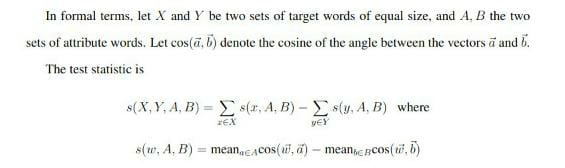





In [ ]:
def swAB(w,A,B):
  return np.mean(cosine_similarity(w,A), axis = 1) - np.mean(cosine_similarity(w,B), axis = 1)

  
def sXYAB(X, Y, A, B):
  return (sum(swAB(X, A, B)) - sum(swAB(Y, A, B)))

### Effect size

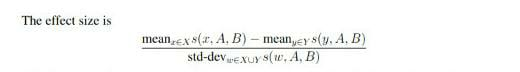

In [ ]:
def weat_effect_size(X, Y, A, B):
  XunionY = list(set(X).union(Y))
  XunionYmat = []
  for w in XunionY:
    XunionYmat.append(glove[w])
  XunionYmat = np.array(XunionYmat)
  #print(XuY)
  #print(XuYmat)
  #print(len(XuY))
  num = np.mean(swAB(Xmat,Amat,Bmat)) - np.mean(swAB(Ymat,Amat,Bmat))
  den = np.std(swAB(XunionYmat, Amat, Bmat),ddof=1) # using ddof=1 to get an unbiased estimate
  return num/den

In [ ]:
weat_effect_size(X,Y,A,B)

1.1705697

In [ ]:
weat_effect_size(X,Y,A,B)

1.1705697

###Getting a random permutation

###Ref: https://docs.python.org/3/library/itertools.html

In [ ]:
def random_permutation(iterable, r=None):
    "Random selection from itertools.permutations(iterable, r)"
    pool = tuple(iterable)
    r = len(pool) if r is None else r
    return tuple(random.sample(pool, r))

#Implementation explanation:

## Using the fact that WEAT effective sizes in the empirical distribution of the null hypothesis are normally distributed.

In [ ]:
def weat_emp_p_value(X, Y, A, B,nsamples):
  #doing it again for small X,Y,A,B

  actualstat = sXYAB(Xmat, Ymat, Amat, Bmat)

  length=len(X)                                     # Since X and Y are of same size 
  assert(len(X)==len(Y))
  X_Y = np.array(X + Y)
  allpartitionsstat = []

  print("checkpoint 0")
  permutations = [random_permutation(X_Y, 2*length) for sample in range(nsamples)]
  count=0
  print("checkpoint 1")
  for mat in permutations:
    count+=1
    if(count%10000==0):
      print(count)
    Xi=mat[:length]
    Yi=mat[length:]
    Ximat = np.array([glove[w] for w in Xi])
    Yimat = np.array([glove[w] for w in Yi])
    allpartitionsstat.append(sXYAB(Ximat, Yimat, Amat, Bmat))
  

  count_above=0
  for particularpartitionstat in allpartitionsstat:
    if particularpartitionstat > actualstat:
      count_above+=1
  
  print(count_above)
  print(len(allpartitionsstat))

  print("checkpoint 3")
  return(count_above/len(allpartitionsstat))

In [ ]:
weat_emp_p_value(X,Y,A,B,1000000)

checkpoint 0
checkpoint 1
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
167018
1000000
checkpoint 3


0.167018

In [ ]:
def weat_p_value(X, Y, A, B,nsamples):
  #doing it again for small X,Y,A,B

  actualstat = sXYAB(Xmat, Ymat, Amat, Bmat)

  length=len(X)                                     # Since X and Y are of same size 
  assert(len(X)==len(Y))
  X_Y = np.array(X + Y)
  allpartitionsstat = []

  print("checkpoint 0")
  permutations = [random_permutation(X_Y, 2*length) for sample in range(nsamples)]
  count=0
  print("checkpoint 1")
  for mat in permutations:
    Xi=mat[:length]
    Yi=mat[length:]
    Ximat = np.array([glove[w] for w in Xi])
    Yimat = np.array([glove[w] for w in Yi])
    allpartitionsstat.append(sXYAB(Ximat, Yimat, Amat, Bmat))
  
  sample_mean = np.mean(allpartitionsstat)
  sample_std = np.std(allpartitionsstat,ddof=1) #using ddof=1 for an unbiased estimate
  p_val = scipy.stats.norm.sf(actualstat, loc=sample_mean, scale=sample_std)
  print("checkpoint 3")
  return(p_val)

In [ ]:
weat_p_value(X,Y,A,B,1000)

checkpoint 0
checkpoint 1
checkpoint 3


0.11773848422977029

# WEFAT


In [ ]:
FW=["Parth"]

In [ ]:
FA=["caress", "freedom", "health", "love", "peace", "cheer", "friend", "heaven", "loyal", "pleasure", "diamond", "gentle", "honest", "lucky", "rainbow", "diploma", "gift", "honor", "miracle", "sunrise", "family", "happy", "laughter", "paradise", "vacation"]
FB=["abuse", "crash", "filth", "murder", "sickness", "accident", "death", "grief", "poison", "stink", "assault", "disaster", "hatred", "pollute", "tragedy", "divorce", "jail", "poverty", "ugly", "cancer", "kill", "rotten", "vomit", "agony", "prison"]



In [ ]:
print(len(FB))
print(len(FA))

25
25


In [ ]:
FWmat=get_glove_emb(FW)
FAmat=get_glove_emb(FA)
FBmat=get_glove_emb(FB)
print(FWmat.shape)
print(FAmat.shape)
print(FBmat.shape)

(1, 300)
(25, 300)
(25, 300)


In [ ]:
def swAB(w,A,B):
  countA=0
  countB=0
  for a in A:
    countA+=(cosine_similarity(w.reshape(1,-1),a.reshape(1,-1)))
  for b in B:
    countB+=(cosine_similarity(w.reshape(1,-1),b.reshape(1,-1)))
  meana=(countA/A.shape[0])
  meanb=(countB/B.shape[0])
  return (meana-meanb).item()

def wefat_effect_size(w, A, B):
  AunionB = list(set(A).union(B))
  AunionBmat = []
  for var in AunionB:
    AunionBmat.append(glove[var])
  AunionBmat = np.array(AunionBmat)
  num = swAB(w,FAmat,FBmat)
  finaloutput=[]
  for variable in AunionBmat:
    finaloutput.append((cosine_similarity(w.reshape(1,-1),variable.reshape(1,-1))).item())
  den = np.std(finaloutput,ddof=1) #using ddof=1 for an unbiased estimate
  #print(num)
  #print(den)
  return num/den

In [ ]:
swAB(FWmat,FAmat,FBmat)

-0.0017014965415000916

In [ ]:
wefat_effect_size(FWmat,FA,FB)


-0.03590634359010653

In [ ]:
def wefat_p_value(w, A, B,nsamples):
  #doing it again for small X,Y,A,B

  actualstat = swAB(w,FAmat,FBmat)

  length=len(A)                                     # Since X and Y are of same size 
  assert(len(B)==len(B))
  A_B = np.array(A + B)
  allpartitionsstat = []
  permutations = [random_permutation(A_B, 2*length) for sample in range(nsamples)]
  print("checkpoint 1")
  count_ab=0
  for mat in permutations:
    Ai=mat[:length]
    Bi=mat[length:]
    Aimat = np.array([glove[w] for w in Ai])
    Bimat = np.array([glove[w] for w in Bi])
    allpartitionsstat.append(swAB(w,Aimat,Bimat))
  

  print("checkpoint 2")
  sample_mean = np.mean(allpartitionsstat)
  sample_std = np.std(allpartitionsstat,ddof=1)
  p_val = scipy.stats.norm.sf(actualstat, loc=sample_mean, scale=sample_std)

  print("checkpoint 3")
  return p_val


def wefat_emp_p_value(w, A, B,nsamples):
  #doing it again for small X,Y,A,B

  actualstat = swAB(w,FAmat,FBmat)

  length=len(A)                                     # Since X and Y are of same size 
  assert(len(B)==len(B))
  A_B = np.array(A + B)
  allpartitionsstat = []
  permutations = [random_permutation(A_B, 2*length) for sample in range(nsamples)]
  print("checkpoint 1")
  count_ab=0
  count=0
  for mat in permutations:
    count+=1
    if(count%10000==0):
      print(count)
    Ai=mat[:length]
    Bi=mat[length:]
    Aimat = np.array([glove[w] for w in Ai])
    Bimat = np.array([glove[w] for w in Bi])
    allpartitionsstat.append(swAB(w,Aimat,Bimat))
  

  count_above=0
  for particularpartitionstat in allpartitionsstat:
    if particularpartitionstat > actualstat:
      count_above+=1
  
  print(count_above)
  print(len(allpartitionsstat))

  print("checkpoint 3")
  return(count_above/len(allpartitionsstat))

In [ ]:
wefat_p_value(FWmat,FA,FB,1000)

checkpoint 1
checkpoint 2
checkpoint 3


0.5486750101066402

In [ ]:
wefat_emp_p_value(FWmat,FA,FB,1000000)

checkpoint 1
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
548877
1000000
checkpoint 3


0.548877

In [ ]:
FW=["weat"]
FWmat=get_glove_emb(FW)
print(FWmat.shape)
wefat_effect_size(FWmat,FA,FB)


(1, 300)


-0.1544695499596644

In [ ]:
wefat_p_value(FWmat,FA,FB,1000)

checkpoint 1
checkpoint 2
checkpoint 3


0.697999303204561

In [ ]:
wefat_emp_p_value(FWmat,FA,FB,1000000)

checkpoint 1
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
704144
1000000
checkpoint 3


0.704144

In [ ]:
FW="AylinCaliskan"


In [ ]:
def get_glove_vec(FW):
  mylist=re.findall('[A-Z][^A-Z]*', FW)
  print(mylist)
  X=np.zeros(300)
  for i in range(len(mylist)):
    X+=np.array(glove[mylist[i]])
  return (X/len(mylist)).reshape(1,-1)

In [ ]:
FWmat=get_glove_vec(FW)
print(FWmat.shape)

['Aylin', 'Caliskan']
(1, 300)


In [ ]:
wefat_effect_size(FWmat,FA,FB)

-0.32843477256190995

In [ ]:
wefat_p_value(FWmat,FA,FB,1000)

checkpoint 1
checkpoint 2
checkpoint 3


0.8734237447363902

In [ ]:
wefat_emp_p_value(FWmat,FA,FB,1000000)

checkpoint 1
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
874219
1000000
checkpoint 3


0.874219